## Amazon Gaming Computers: Model Building

In [418]:
import numpy as np
import pandas as pd
from scipy import stats
import optuna

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, r2_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from catboost import CatBoostRegressor

from xgboost import XGBRegressor
import xgboost
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [285]:
df = pd.read_csv("amazon_gaming_desktops_posteda.csv")
df.drop(columns=['Unnamed: 0'], inplace=True)
df.shape

(3805, 15)

In [286]:
#Re-ordering columns so the target is at the end.
new_order_cols = ['Product Name', 'Avg. Rating', '# Ratings', 'Processor Type', 'Disk Size', 'RAM', 'Processor Speed', 'Brand', 'Bluetooth',
     'Liq. Cooled', 'RAM: Type', 'RAM : GB', 'Processor Speed: GHz', 'Disk Size: GB', 'Price']
df = df[new_order_cols]
df.shape

(3805, 15)

In [287]:
df.head()

,Product Name,Avg. Rating,# Ratings,Processor Type,Disk Size,RAM,Processor Speed,Brand,Bluetooth,Liq. Cooled,RAM: Type,RAM : GB,Processor Speed: GHz,Disk Size: GB,Price
0,MSI Aegis RS 12TG-261 Gaming & Entertainment D...,0.0,0,Intel Core i7,8 TB,64 GB,3.60 GHz,MSI,0,0,GB,64.0,3.6,8000.0,8679.0
1,MSI Aegis RS 12TG-261 Gaming & Entertainment D...,0.0,0,Intel Core i7,16 TB,64 GB,3.60 GHz,MSI,1,0,GB,64.0,3.6,16000.0,8589.0
2,MSI Aegis RS 12TG-261 Gaming & Entertainment D...,0.0,0,Intel Core i7,8 TB,64 GB,3.60 GHz,MSI,1,0,GB,64.0,3.6,8000.0,8589.0
3,MSI Aegis RS 12TG-261 Gaming & Entertainment D...,0.0,0,Intel Core i7,16 TB,64 GB,3.60 GHz,MSI,1,0,GB,64.0,3.6,16000.0,8569.0
4,MSI Aegis RS 12TG-261 Gaming & Entertainment D...,0.0,0,Intel Core i7,8 TB,64 GB,3.60 GHz,MSI,1,0,GB,64.0,3.6,8000.0,8569.0


## Missing Value Imputation

We have already taken care of imputing any missing values previously in the project.

In [288]:
df.isnull().sum() #We have already taken care of any missing values

Product Name            0
Avg. Rating             0
# Ratings               0
Processor Type          0
Disk Size               0
RAM                     0
Processor Speed         0
Brand                   0
Bluetooth               0
Liq. Cooled             0
RAM: Type               0
RAM : GB                0
Processor Speed: GHz    0
Disk Size: GB           0
Price                   0
dtype: int64

## Outlier Detection & Removal

We want to remove those extreme outliers we noticed while performing EDA. For this project, I will be using the <b>Z-score</b> for outlier detection. Of course we want to do this on the numeric columns in question.

In [289]:
z = np.abs(stats.zscore(df[['RAM : GB', 'Processor Speed: GHz', 'Disk Size: GB']]))
z

array([[0.01208336, 0.3702926 , 0.2728383 ],
       [0.01208336, 0.3702926 , 0.81579091],
       [0.01208336, 0.3702926 , 0.2728383 ],
       ...,
       [0.03418108, 0.27369644, 0.13437616],
       [0.04189182, 0.27369644, 0.23617977],
       [0.04189182, 0.27369644, 0.23617977]])

In [290]:
print('RAM : GB Z-Score values: min: {}, max: {}, mean: {}'.format(z[:, 0].min(), z[:, 0].max(), np.mean(z[:, 0])))
print('Processor Speed: GHz Z-Score values: min: {}, max: {}, mean: {}'.format(z[:, 1].min(), z[:, 1].max(), np.mean(z[:, 1])))
print('Disk Size: GB Z-Score values: min: {}, max: {}, mean: {}'.format(z[:, 2].min(), z[:, 2].max(), np.mean(z[:, 2])))

RAM : GB Z-Score values: min: 0.0033381163297653586, max: 61.6363210375879, mean: 0.04523060031936474
Processor Speed: GHz Z-Score values: min: 0.0482980777826913, max: 5.4256087503595305, mean: 0.7132778937142505
Disk Size: GB Z-Score values: min: 0.0013619958301242451, max: 34.47885256559381, mean: 0.22217778950898656


In [291]:
threshold = 2
outlier_indices = np.where(z > threshold)[0] #row indices
print(outlier_indices)

#50 Rows when threshold is 3
#187 Rows when threshold is 2

[  22  142  252  283  436  574  589  668  672  673  698  706  752  777
  791  801  819  838  838  891  934 1023 1024 1028 1030 1069 1101 1103
 1124 1131 1135 1161 1162 1164 1220 1225 1241 1253 1285 1287 1294 1305
 1307 1331 1332 1337 1361 1399 1401 1409 1415 1442 1443 1458 1463 1464
 1473 1481 1517 1522 1533 1535 1536 1542 1550 1567 1569 1570 1579 1581
 1589 1599 1600 1602 1612 1613 1618 1621 1622 1646 1660 1670 1688 1691
 1698 1699 1705 1715 1729 1765 1774 1797 1810 1813 1814 1845 1858 1880
 1883 1907 1909 1911 1913 1914 1934 1936 1965 2012 2038 2041 2043 2132
 2135 2140 2141 2151 2159 2180 2182 2239 2240 2254 2272 2343 2391 2393
 2396 2404 2441 2479 2486 2488 2505 2525 2526 2553 2573 2604 2621 2686
 2704 2721 2740 2741 2756 2759 2791 2809 2847 2870 2957 2992 3003 3025
 3031 3064 3076 3079 3084 3090 3120 3150 3195 3204 3215 3254 3256 3271
 3292 3295 3299 3363 3440 3446 3476 3482 3488 3517 3560 3592 3603 3606
 3620 3637 3705 3735 3754]


Since our data is quite sensitive to outliers, I will elect to set a threshold of 2. We'll still have enough data to utilize for our model building. We still have a bigger difference coming once we drop the rows from categorical columns of high cardinality with low volume in the data we have.

In [292]:
df_or = df.drop(outlier_indices, axis=0)

In [293]:
df_or.shape

(3619, 15)

Now let's try to remove records from high cardinality categorical columns that appear extremely infrequently (namely Brand, Processor Type).

In [294]:
#Processor Type
proc_types = ['Intel Core i3', 'Intel Core i5', 'Intel Core i7', 'Intel Core i9', 'Ryzen 3', 'Ryzen 5', 'Ryzen 7', 'Ryzen 9', 'AMD A Series', 'AMD R Series']

df_or = df_or[df_or['Processor Type'].isin(proc_types)]

In [295]:
df_or.shape

(3564, 15)

In [296]:
#Brand

brand_select = df_or['Brand'].value_counts().index.tolist()[:15]

df_or = df_or[df_or['Brand'].isin(brand_select)]

In [297]:
df_or.shape

(3427, 15)

We now need to check the columns we used for outlier removal since they are not continuous.

I'll elect to keep the RAM values that are powers of 2.

In [298]:
df_or['RAM : GB'].value_counts() #

32.000000      1113
16.000000       889
64.000000       601
8.000000        396
24.000000       179
128.000000      167
12.000000        31
0.000000         24
4.000000         11
256.000000        7
10.000000         3
1000.000000       2
0.000008          1
6.000000          1
2.000000          1
512.000000        1
Name: RAM : GB, dtype: int64

In [299]:
final_ram_cols = [2.0, 4.0, 8.0, 12.0, 16.0, 24.0, 32.0, 64.0, 128.0, 256.0] #we'll keep 24 since it is quite common
df_or = df_or[df_or['RAM : GB'].isin(final_ram_cols)]

In [300]:
#Disk Size we can probably keep at continous as is since have already taken out the outliers.

In [301]:
# We can also keep Processor Speed GHz as is for the same reasons.

In [302]:
#Let's next discount the extremely low represented brands/makers
df_or.head()

,Product Name,Avg. Rating,# Ratings,Processor Type,Disk Size,RAM,Processor Speed,Brand,Bluetooth,Liq. Cooled,RAM: Type,RAM : GB,Processor Speed: GHz,Disk Size: GB,Price
0,MSI Aegis RS 12TG-261 Gaming & Entertainment D...,0.0,0,Intel Core i7,8 TB,64 GB,3.60 GHz,MSI,0,0,GB,64.0,3.6,8000.0,8679.0
1,MSI Aegis RS 12TG-261 Gaming & Entertainment D...,0.0,0,Intel Core i7,16 TB,64 GB,3.60 GHz,MSI,1,0,GB,64.0,3.6,16000.0,8589.0
2,MSI Aegis RS 12TG-261 Gaming & Entertainment D...,0.0,0,Intel Core i7,8 TB,64 GB,3.60 GHz,MSI,1,0,GB,64.0,3.6,8000.0,8589.0
3,MSI Aegis RS 12TG-261 Gaming & Entertainment D...,0.0,0,Intel Core i7,16 TB,64 GB,3.60 GHz,MSI,1,0,GB,64.0,3.6,16000.0,8569.0
4,MSI Aegis RS 12TG-261 Gaming & Entertainment D...,0.0,0,Intel Core i7,8 TB,64 GB,3.60 GHz,MSI,1,0,GB,64.0,3.6,8000.0,8569.0


In [303]:
included_brands = ['Dell', 'Adamant', 'HP', 'Velztorm', 'MSI', 'Lenovo', 'CLX', 'SkyTech', 'OMEN', 'CUK', 'Alienware', 'Acer', 'ASUS ROG', 'CyerpowerPC', 'iBUYPOWER']
df_or = df_or[df_or['Brand'].isin(included_brands)]

In [304]:
df_or.head()

,Product Name,Avg. Rating,# Ratings,Processor Type,Disk Size,RAM,Processor Speed,Brand,Bluetooth,Liq. Cooled,RAM: Type,RAM : GB,Processor Speed: GHz,Disk Size: GB,Price
0,MSI Aegis RS 12TG-261 Gaming & Entertainment D...,0.0,0,Intel Core i7,8 TB,64 GB,3.60 GHz,MSI,0,0,GB,64.0,3.6,8000.0,8679.0
1,MSI Aegis RS 12TG-261 Gaming & Entertainment D...,0.0,0,Intel Core i7,16 TB,64 GB,3.60 GHz,MSI,1,0,GB,64.0,3.6,16000.0,8589.0
2,MSI Aegis RS 12TG-261 Gaming & Entertainment D...,0.0,0,Intel Core i7,8 TB,64 GB,3.60 GHz,MSI,1,0,GB,64.0,3.6,8000.0,8589.0
3,MSI Aegis RS 12TG-261 Gaming & Entertainment D...,0.0,0,Intel Core i7,16 TB,64 GB,3.60 GHz,MSI,1,0,GB,64.0,3.6,16000.0,8569.0
4,MSI Aegis RS 12TG-261 Gaming & Entertainment D...,0.0,0,Intel Core i7,8 TB,64 GB,3.60 GHz,MSI,1,0,GB,64.0,3.6,8000.0,8569.0


In [305]:
df_or.shape

(3365, 15)

### Multicollinearity Check
Since we have some suspecting attriubtes that may be correlated with each other (namely Avg. Rating and # Ratings), I'll plot a heatmap to check for multicollinearity among the variables.

We'll also check correlation with the target here as well.

<ipython-input-306-f9085c97851f>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df_or.loc[:, :'Disk Size: GB'].corr(), dtype=np.bool))


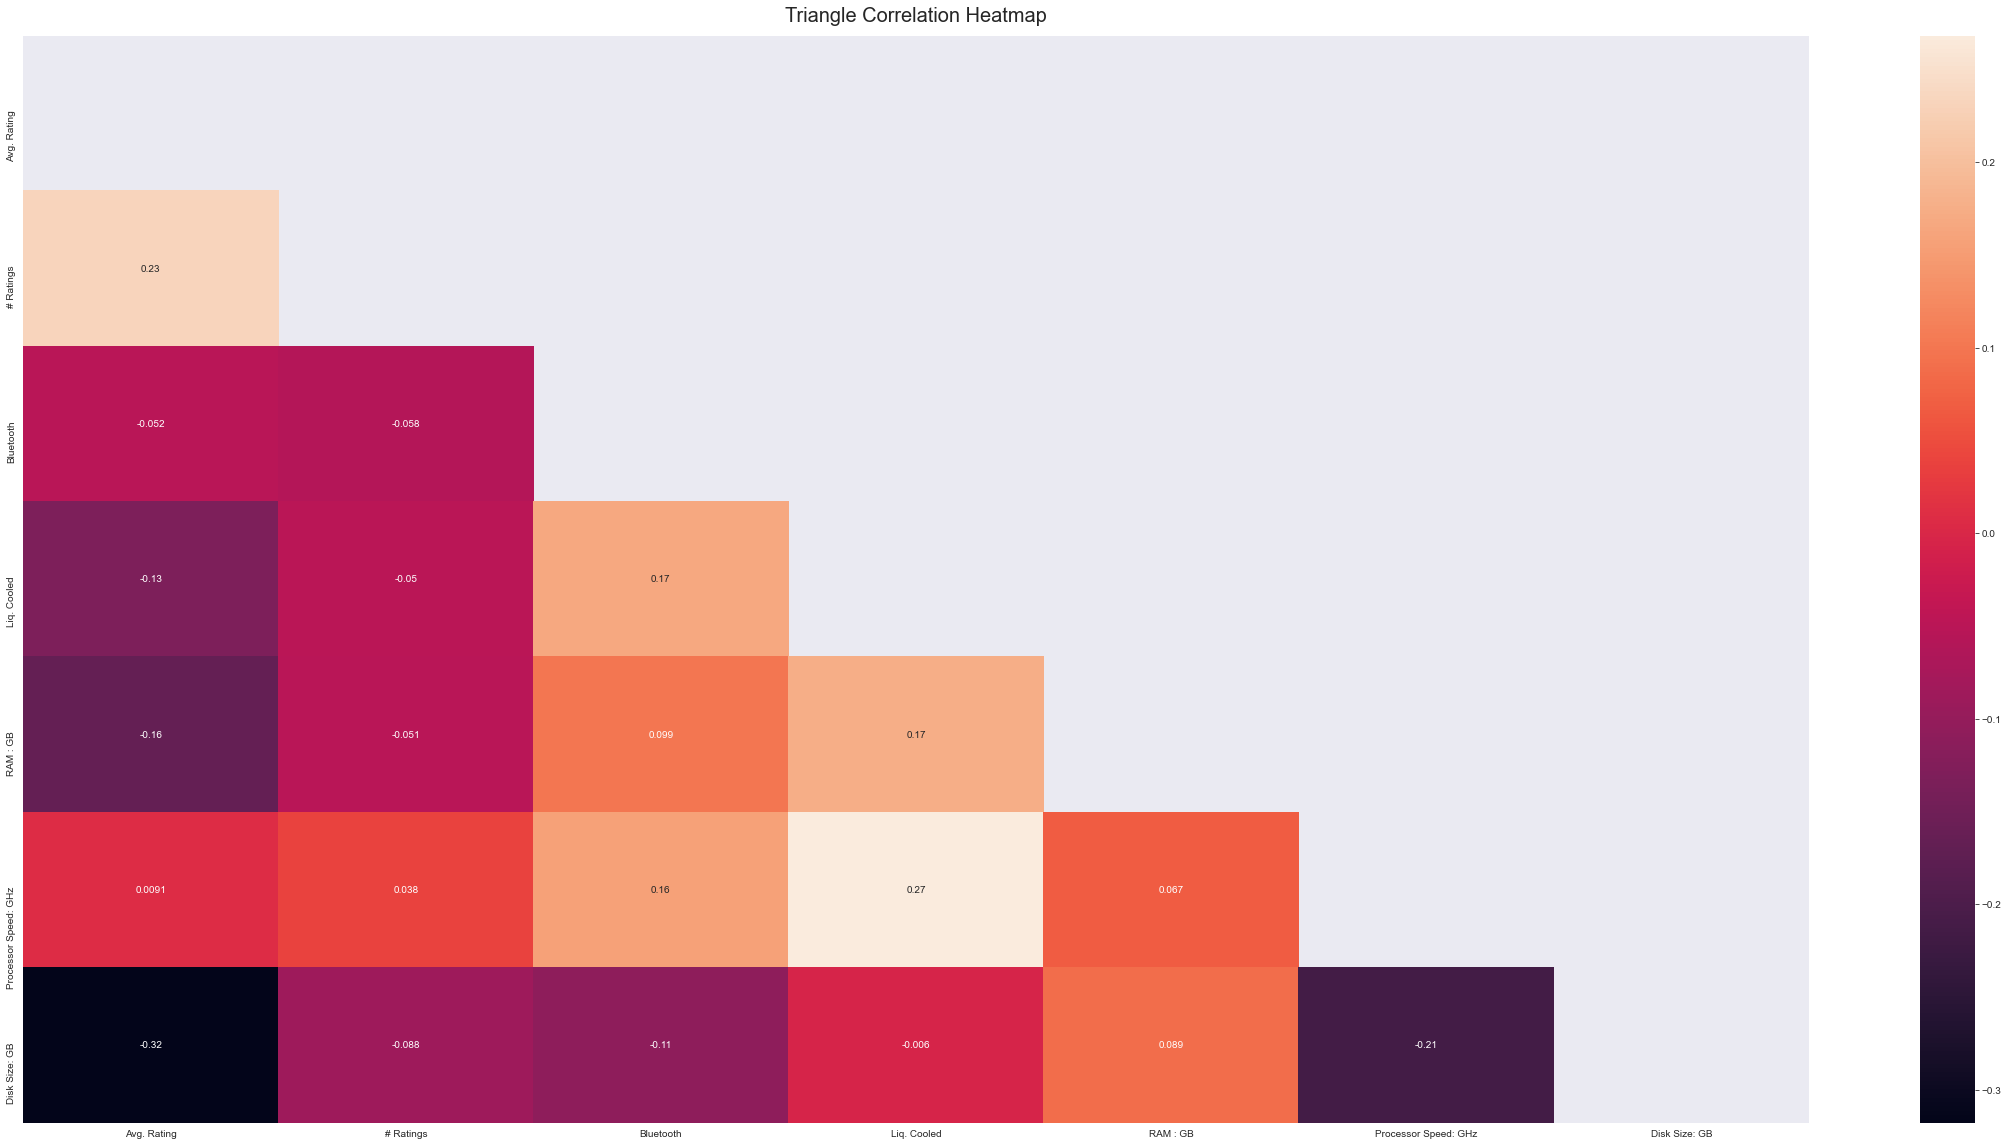

In [306]:
plt.figure(figsize=(40, 20))
mask = np.triu(np.ones_like(df_or.loc[:, :'Disk Size: GB'].corr(), dtype=np.bool))
heatmap = sns.heatmap(df_or.loc[:, :'Disk Size: GB'].corr(), annot=True, mask=mask)
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':20}, pad=14);

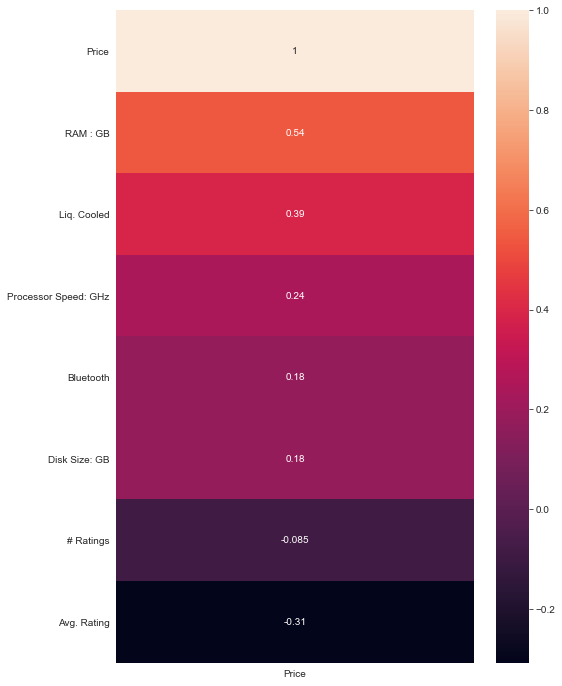

In [307]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df_or.corr()[['Price']].sort_values(by='Price', ascending=False), annot=True)

They don't return very high values here, but we know they are one in the same since the avg. rating will be 0 if there are no ratings for a given product. Nothing else seems to have very high collinearity, so we'll keep the attributes as they are for now.

Next we'll take out the columns and keep only the final ones for further development.

In [308]:
df_new = df_or[['Avg. Rating', '# Ratings', 'Processor Type', 'Brand', 'Bluetooth', 'Liq. Cooled', 'RAM : GB', 'Processor Speed: GHz', 'Disk Size: GB', 'Price']].copy()
df_new.head()

,Avg. Rating,# Ratings,Processor Type,Brand,Bluetooth,Liq. Cooled,RAM : GB,Processor Speed: GHz,Disk Size: GB,Price
0,0.0,0,Intel Core i7,MSI,0,0,64.0,3.6,8000.0,8679.0
1,0.0,0,Intel Core i7,MSI,1,0,64.0,3.6,16000.0,8589.0
2,0.0,0,Intel Core i7,MSI,1,0,64.0,3.6,8000.0,8589.0
3,0.0,0,Intel Core i7,MSI,1,0,64.0,3.6,16000.0,8569.0
4,0.0,0,Intel Core i7,MSI,1,0,64.0,3.6,8000.0,8569.0


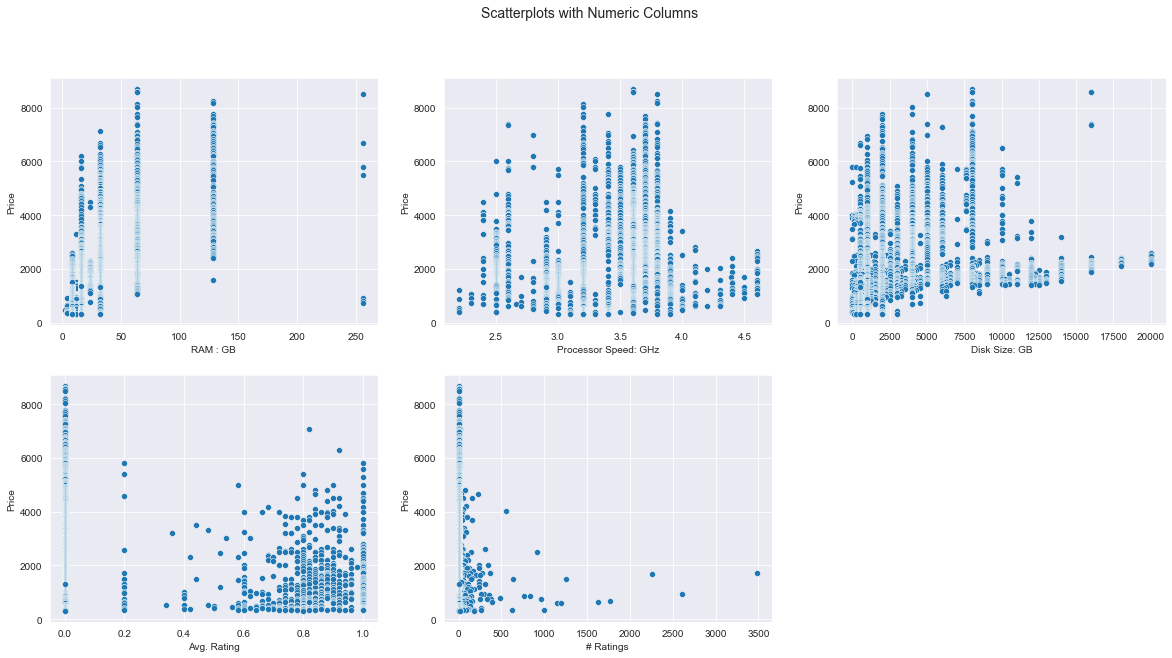

In [309]:
num_cols = ['RAM : GB', 'Processor Speed: GHz', 'Disk Size: GB', 'Avg. Rating', '# Ratings']

i = 1
plt.figure(figsize=(20,10))
plt.suptitle('Scatterplots with Numeric Columns', fontsize=14)
for col in num_cols:
    plt.subplot(2,3,i)
    sns.scatterplot(x=col, y='Price', data=df_new)
    i = i + 1

This further backs the notion that for some products, the brand greatly enhances the price. Looking at the rating columns (if we choose to keep them), I suspect they will be heavily skewed.

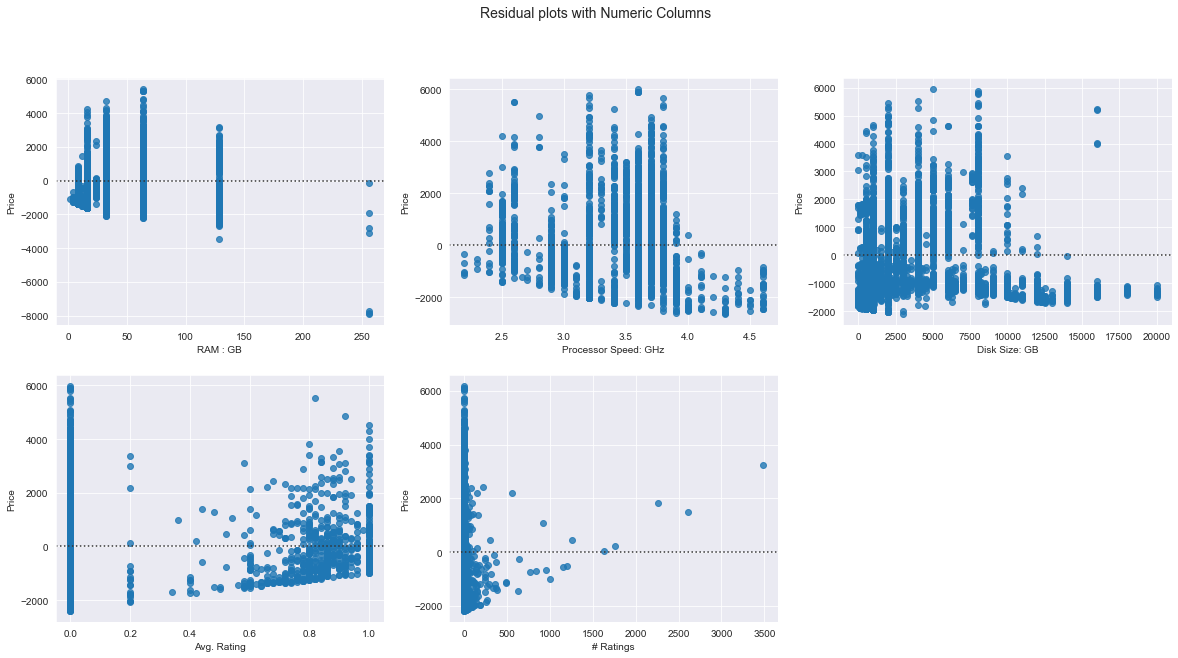

In [310]:
i = 1
plt.figure(figsize=(20,10))
plt.suptitle('Residual plots with Numeric Columns', fontsize=14)
for col in num_cols:
    plt.subplot(2,3,i)
    sns.residplot(x=col, y='Price', data=df_new)
    i = i + 1

When checking for <b>autocorrelation</b>, we can make residual plots. We can see there aren't any patterns and the data is mostly random across these plots, so this point checks out, minus the points made previously about the ratings columns.

At this point, we need to start transforming our attributes.

### Mutual Information Regression Analysis

Another good technique we can use is the MI of each attribute. This way we can get another metric of perspective on the influence of an attribute to the target in question.

In [311]:
X = df_new.copy()
y = df_new['Price'].copy()

In [312]:
X.pop('Price')

for col in X.select_dtypes("object"):
    X[col], _ = X[col].factorize()

discrete_features = X.dtypes == int

In [313]:
mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

Text(0.5, 1.0, 'Mutual Information Scores')

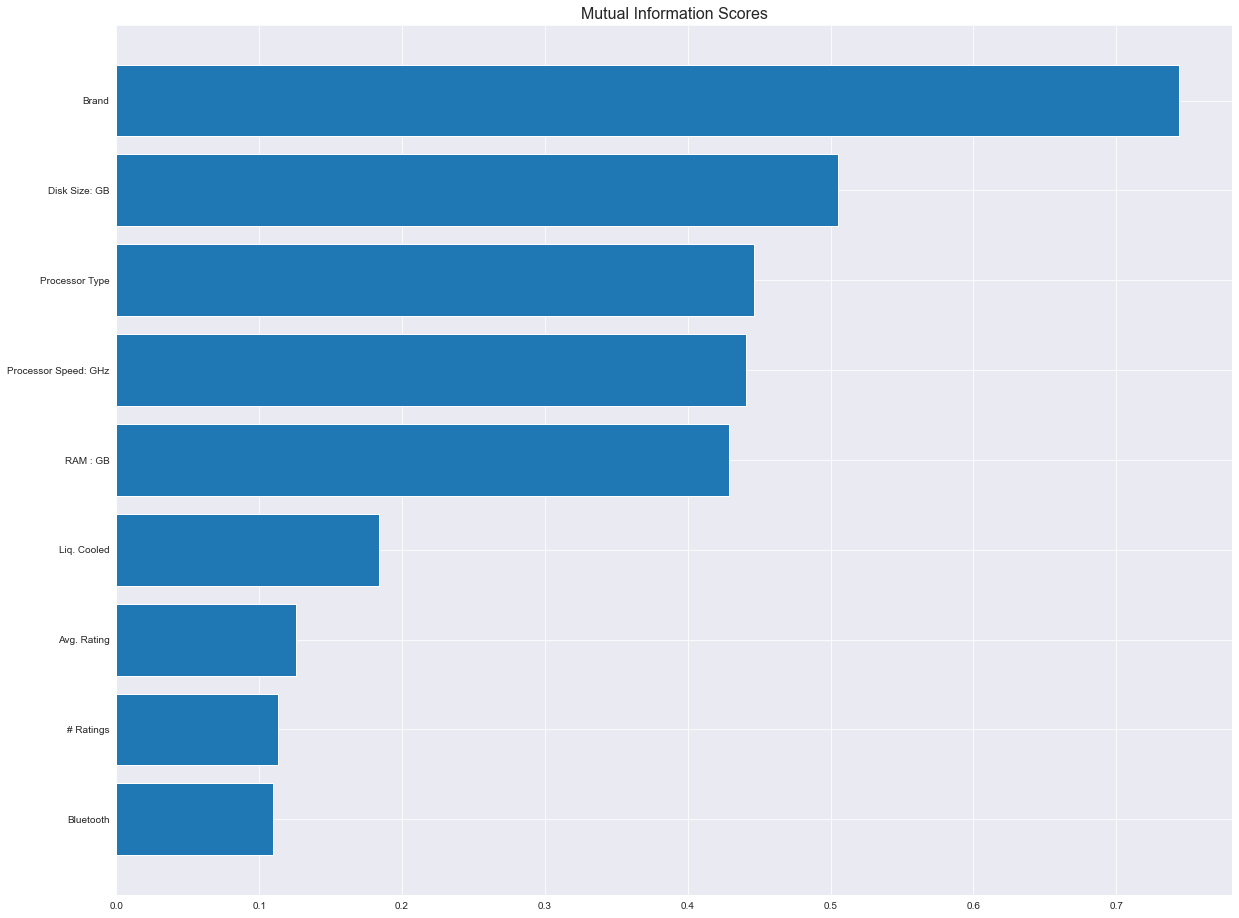

In [314]:
plt.figure(figsize=(20, 16))

mi_scores = mi_scores.sort_values(ascending=True)
width = np.arange(len(mi_scores))
ticks = list(mi_scores.index)
plt.barh(width, mi_scores)
plt.yticks(width, ticks)
plt.title("Mutual Information Scores", fontsize=16)

As hypothesized before, the brand of a computer has the largest influence on price, followed by the four attributes of the computer provided on the listings from Amazon.

## Variable Transformation

We first need to encode our categorical data.

We'll use the order for processor type using our findings from the EDA. For our chosen brands, we'll first look at their distribution to the price.

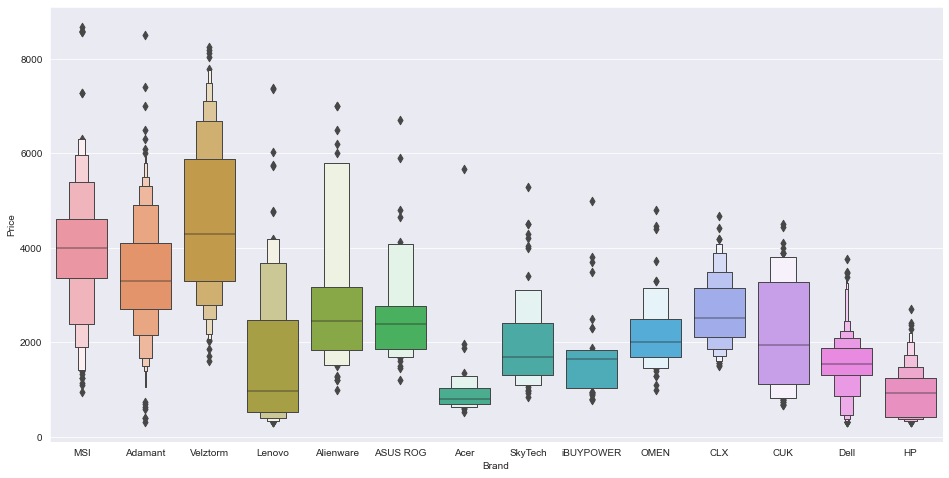

In [315]:
plt.figure(figsize=(16,8))
sns.boxenplot(data=df_new, x='Brand', y='Price')
plt.show()

Since we'll still have few total columns if we use dummy variables for the Brand, making this ordinal may skew some of the true prices of a brand, since there could be sub-groups of brands with respect to price.

Therefore, I will elect to one-hot encode the brand attribute.

In [ ]:
#If you want to try ordinal: we can do so here: make sure to comment out dummy parts if you do.
#df_with_dummies = df_new.copy()

#d = {'Acer': 1, 'HP':2, 'Dell':3, 'Lenovo':4, 'iBUYPOWER':5, 'SkyTech':6, 'CUK':7, 'OMEN':8, 'ASUS ROG':9, 'CLX':10, 'Alienware':11, 'Adamant':12, 'MSI':13, 'Velztorm':14}
#df_with_dummies['Brand'] = df_with_dummies['Brand'].replace(d)

In [317]:
brand_dummies = pd.get_dummies(df_new['Brand'], prefix='Brand')
brand_dummies

,Brand_ASUS ROG,Brand_Acer,Brand_Adamant,Brand_Alienware,Brand_CLX,Brand_CUK,Brand_Dell,Brand_HP,Brand_Lenovo,Brand_MSI,Brand_OMEN,Brand_SkyTech,Brand_Velztorm,Brand_iBUYPOWER
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3799,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3800,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3801,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3802,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [318]:
#Comment out below if you don't want to use dummies

df_with_dummies = pd.concat([brand_dummies, df_new], axis=1) #If ordering is better, we could try it.
df_with_dummies.drop(columns=['Brand'], inplace=True)
df_with_dummies.head()

,Brand_ASUS ROG,Brand_Acer,Brand_Adamant,Brand_Alienware,Brand_CLX,Brand_CUK,Brand_Dell,Brand_HP,Brand_Lenovo,Brand_MSI,Brand_OMEN,Brand_SkyTech,Brand_Velztorm,Brand_iBUYPOWER,Avg. Rating,# Ratings,Processor Type,Bluetooth,Liq. Cooled,RAM : GB,Processor Speed: GHz,Disk Size: GB,Price
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0,Intel Core i7,0,0,64.0,3.6,8000.0,8679.0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0,Intel Core i7,1,0,64.0,3.6,16000.0,8589.0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0,Intel Core i7,1,0,64.0,3.6,8000.0,8589.0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0,Intel Core i7,1,0,64.0,3.6,16000.0,8569.0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0,Intel Core i7,1,0,64.0,3.6,8000.0,8569.0


In [319]:
df_with_dummies['Processor Type'].value_counts()

Intel Core i7    1292
Intel Core i5     617
Intel Core i9     518
AMD R Series      429
Ryzen 7           222
Ryzen 5           148
Ryzen 9            96
Intel Core i3      30
AMD A Series        7
Ryzen 3             6
Name: Processor Type, dtype: int64

In [320]:
#proc type order: [Intel Core i3, Ryzen 3, AMD A Series, Ryzen 5, Intel Core i5, Intel Core i7, Ryzen 7, AMD R Series, Ryzen 9, Intel Core i9]

In [321]:
d = {'Intel Core i3': 1, 'Ryzen 3':2, 'AMD A Series':3, 'Ryzen 5':4, 'Intel Core i5':5, 'Intel Core i7': 6, 'Ryzen 7':7, 'AMD R Series':8, 'Ryzen 9':9, 'Intel Core i9':10}
df_with_dummies['Processor Type'] = df_with_dummies['Processor Type'].replace(d)

In [322]:
df_with_dummies.head()

,Brand_ASUS ROG,Brand_Acer,Brand_Adamant,Brand_Alienware,Brand_CLX,Brand_CUK,Brand_Dell,Brand_HP,Brand_Lenovo,Brand_MSI,Brand_OMEN,Brand_SkyTech,Brand_Velztorm,Brand_iBUYPOWER,Avg. Rating,# Ratings,Processor Type,Bluetooth,Liq. Cooled,RAM : GB,Processor Speed: GHz,Disk Size: GB,Price
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0,6,0,0,64.0,3.6,8000.0,8679.0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0,6,1,0,64.0,3.6,16000.0,8589.0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0,6,1,0,64.0,3.6,8000.0,8589.0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0,6,1,0,64.0,3.6,16000.0,8569.0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0,6,1,0,64.0,3.6,8000.0,8569.0


Now that all of our columns are numeric, <b>we can now look at skewness and normality.</b>

In [323]:
skew_list = []
for col in df_with_dummies.columns:
    if np.abs(df_with_dummies[col].skew()) > 1.0:
        skew_list.append((col, df_with_dummies[col].skew()))
skew_df = pd.DataFrame(skew_list).sort_values(by=1, ascending=False)
skew_df

,0,1
14,# Ratings,19.216180
12,Brand_iBUYPOWER,10.278709
1,Brand_Acer,10.112221
0,Brand_ASUS ROG,9.655904
3,Brand_Alienware,8.786382
9,Brand_OMEN,8.108443
5,Brand_CUK,7.355268
10,Brand_SkyTech,7.226960
7,Brand_Lenovo,5.130275
4,Brand_CLX,4.832124


We'll log transform these columns that are skewed, since we have no attributes with negative values.

In [324]:
skewed_cols = skew_df[0]
skewed_cols = skewed_cols.values.tolist()

In [325]:
for col in skewed_cols:
    df_with_dummies[col] = df_with_dummies[col].apply(np.log1p)

In [326]:
df_with_dummies.head()

,Brand_ASUS ROG,Brand_Acer,Brand_Adamant,Brand_Alienware,Brand_CLX,Brand_CUK,Brand_Dell,Brand_HP,Brand_Lenovo,Brand_MSI,Brand_OMEN,Brand_SkyTech,Brand_Velztorm,Brand_iBUYPOWER,Avg. Rating,# Ratings,Processor Type,Bluetooth,Liq. Cooled,RAM : GB,Processor Speed: GHz,Disk Size: GB,Price
0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.693359,0.0,0.0,0.0,0.0,0.0,0.0,6,0,0.0,4.174387,3.6,8.987322,8679.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.693359,0.0,0.0,0.0,0.0,0.0,0.0,6,1,0.0,4.174387,3.6,9.680406,8589.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.693359,0.0,0.0,0.0,0.0,0.0,0.0,6,1,0.0,4.174387,3.6,8.987322,8589.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.693359,0.0,0.0,0.0,0.0,0.0,0.0,6,1,0.0,4.174387,3.6,9.680406,8569.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.693359,0.0,0.0,0.0,0.0,0.0,0.0,6,1,0.0,4.174387,3.6,8.987322,8569.0


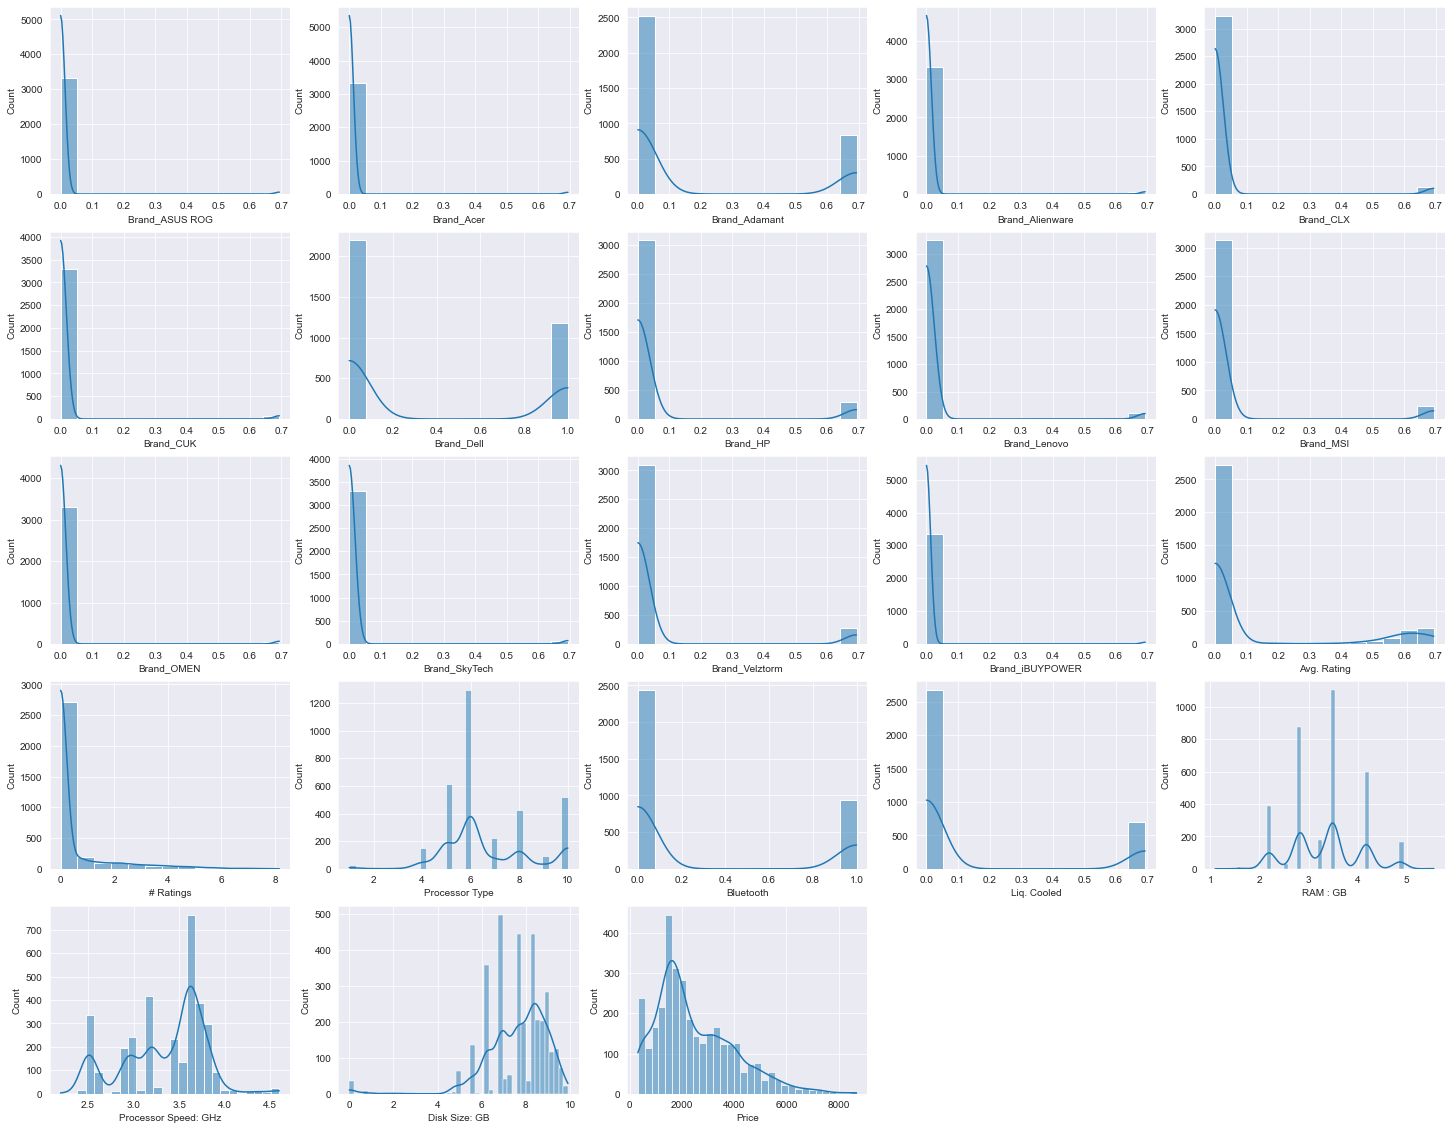

In [327]:
i = 1
plt.figure(figsize=(25,20))

for col in df_with_dummies.columns:
    plt.subplot(5,5,i)
    sns.histplot(x=col, data=df_with_dummies, kde=True)
    i = i + 1

The columns now appear more normally distributed.

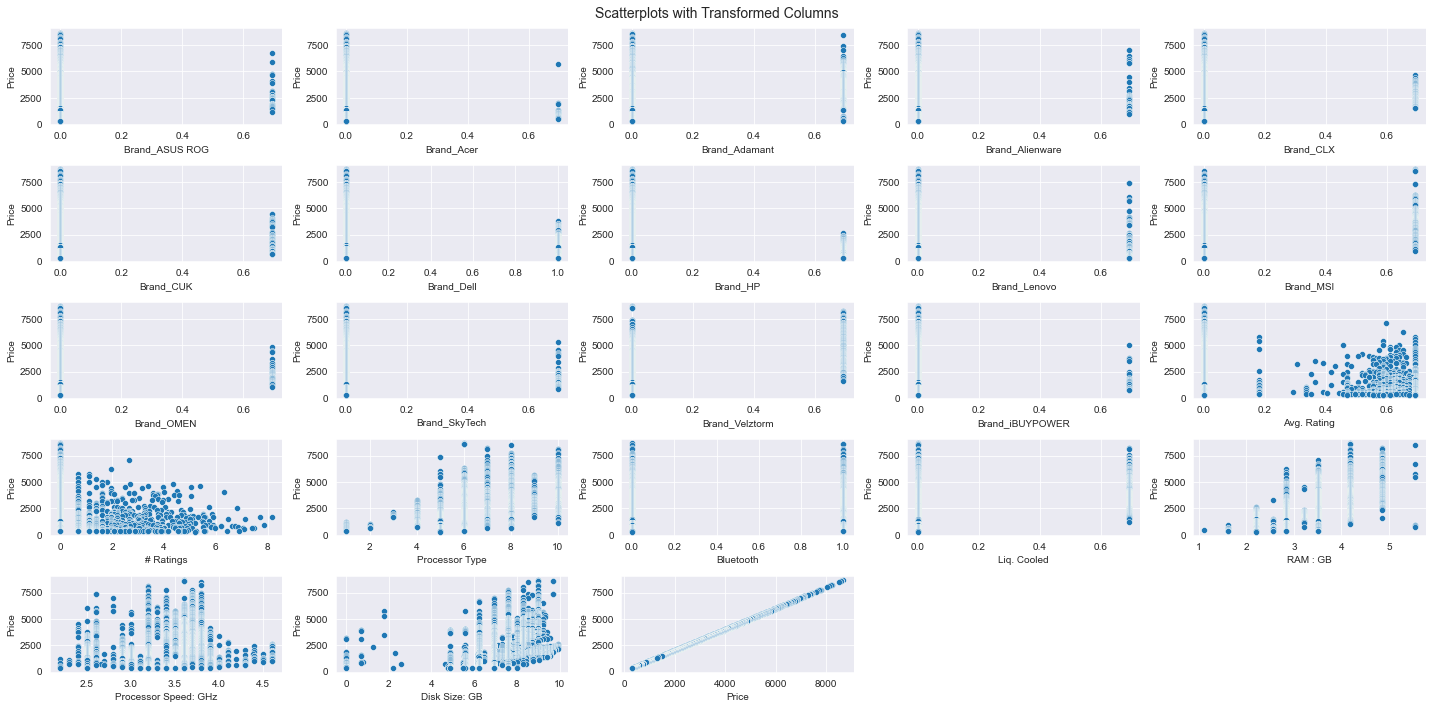

In [328]:
i = 1
plt.figure(figsize=(20,10))
plt.suptitle('Scatterplots with Transformed Columns', fontsize=14)
for col in df_with_dummies.columns.tolist():
    plt.subplot(5,5,i)
    sns.scatterplot(x=col, y='Price', data=df_with_dummies)
    i = i + 1
plt.tight_layout()

## Model Construction

Since we may still have some attributes that are not efficacious to a model judging by their relation to price, we can use the Lasso regression algorithm, since it has built-in normalization. We'll also try Ridge and the combination of the two: ElasticNet (using their cross validation versions).

In [329]:
df_with_dummies.head()

,Brand_ASUS ROG,Brand_Acer,Brand_Adamant,Brand_Alienware,Brand_CLX,Brand_CUK,Brand_Dell,Brand_HP,Brand_Lenovo,Brand_MSI,Brand_OMEN,Brand_SkyTech,Brand_Velztorm,Brand_iBUYPOWER,Avg. Rating,# Ratings,Processor Type,Bluetooth,Liq. Cooled,RAM : GB,Processor Speed: GHz,Disk Size: GB,Price
0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.693359,0.0,0.0,0.0,0.0,0.0,0.0,6,0,0.0,4.174387,3.6,8.987322,8679.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.693359,0.0,0.0,0.0,0.0,0.0,0.0,6,1,0.0,4.174387,3.6,9.680406,8589.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.693359,0.0,0.0,0.0,0.0,0.0,0.0,6,1,0.0,4.174387,3.6,8.987322,8589.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.693359,0.0,0.0,0.0,0.0,0.0,0.0,6,1,0.0,4.174387,3.6,9.680406,8569.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.693359,0.0,0.0,0.0,0.0,0.0,0.0,6,1,0.0,4.174387,3.6,8.987322,8569.0


In [330]:
X = df_with_dummies.loc[:, :'Disk Size: GB']
y = df_with_dummies.loc[:, 'Price']

In [337]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3, test_size=0.25)

In [338]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
"""

WE COULD ALSO TRY TO USE PCA TO MAKE FEATURES IF IT HELPS. if we are going to try it...


"""

### Linear Models

In [339]:
reg = LassoCV(cv=5, random_state=3).fit(X_train, y_train)
print('Lasso Regression R2 Score: {}'.format(reg.score(X_test, y_test)))
y_pred = reg.predict(X_test)

Lasso Regression R2 Score: 0.7214600447196793


In [340]:
#Lasso:
#R2 with dummies: 72.15
#R2 with ordered brands: 70.14.

In [341]:
reg = RidgeCV(cv=5).fit(X_train, y_train)
print('Ridge Regression R2 Score: {:.2%}'.format(reg.score(X_test, y_test)))
y_pred = reg.predict(X_test)

Ridge Regression R2 Score: 0.7216695827163415


In [342]:
reg = RidgeCV(cv=5).fit(X_train, y_train)
print('ElasticNet Regression R2 Score: {:.2%}'.format(reg.score(X_test, y_test)))
y_pred = reg.predict(X_test)

ElasticNet Regression R2 Score: 0.7216695827163415


In [346]:
#Standard Linear Regression:
reg = LinearRegression(positive=True).fit(X_train, y_train)
print('Linear Regression R2 Score: {:.2%}'.format(reg.score(X_test, y_test)))

#Obtains better result with values fixed to positive.

Linear Regression R2 Score: 0.7228549554292469


### Random Forest Regression

We got similar results across the board for each linear regression model used. I'll now try to use random forest regression on the data and see what we obtain.

In [347]:
rf = RandomForestRegressor(n_estimators=1000, random_state=3).fit(X_train, y_train)

In [349]:
print('Random Forest Regression R2 Score: {:.2%}'.format(rf.score(X_test, y_test)))

Linear Regression R2 Score: 0.8376697769097994


We get pretty good results with Random Forest Regression. This does make sense seeing as we have a lot of binary 0/1 attributes. We can also look at its recorded feature importances.

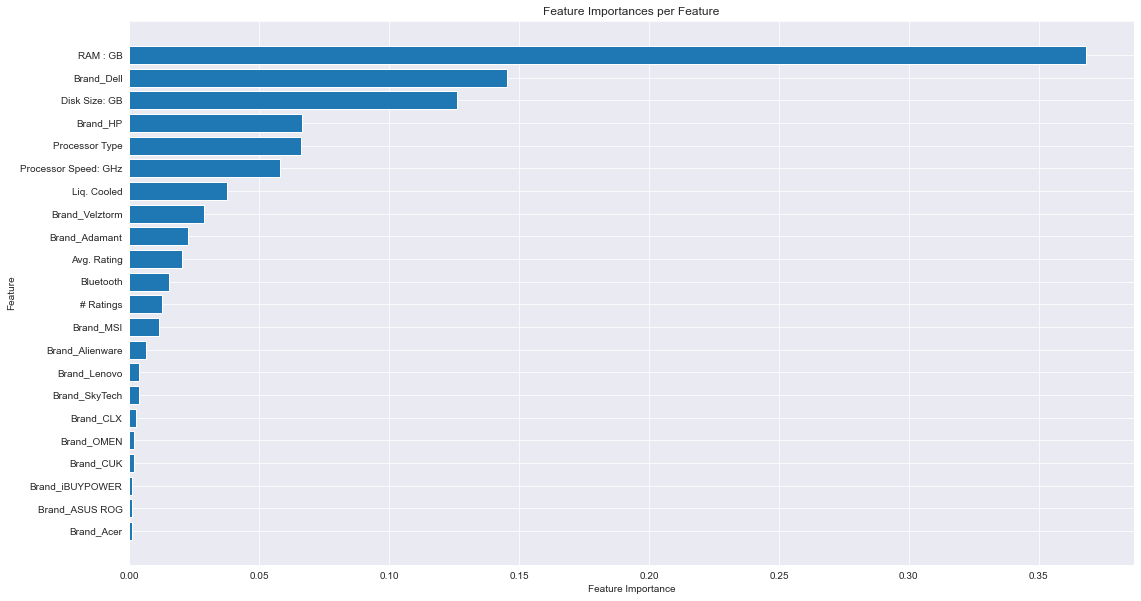

In [350]:
feat_imps =  pd.DataFrame({'Feature':X.columns, 'Importance Metric':rf.feature_importances_.round(4)}).sort_values(by='Importance Metric', ascending=False)

plt.figure(figsize=(18, 10))
plt.barh(feat_imps['Feature'], feat_imps['Importance Metric'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances per Feature')
plt.gca().invert_yaxis()
plt.show()

We can see some brands are clumped at the bottom while some brands offer much importance to the model in addition to some computer specs. The brands with less records come at the bottom here, so of course the brands with more records are more important to the model.

In [351]:
#Next we can try optuna with XGBoost Regressor and see what we get.

### XGBoost Regression w/ Optuna

Now I would like to try XGBoost Regression using the wonderful Optuna library. We can either minimize for mean squared error, or maximize for r2 score.

In [379]:
def objective(trial, X=X, y=y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3, test_size=0.25)
    
    param_grid = {
        'tree_method':'gpu_hist',  
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 4000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    
    xgbreg = XGBRegressor(**param_grid)  
    
    xgbreg.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    
    y_pred = xgbreg.predict(X_test)
    
    #rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    #return rmse 
    return r2

In [380]:
study = optuna.create_study(direction='maximize') #if r2, do maximize
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-04-12 16:51:12,123] A new study created in memory with name: no-name-4382a51c-8c87-4f83-b456-5ca23aac3ab7
[I 2022-04-12 16:51:15,082] Trial 0 finished with value: 0.5003304205520678 and parameters: {'lambda': 5.018579902014747, 'alpha': 0.004081739948549472, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.018, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 288}. Best is trial 0 with value: 0.5003304205520678.
[I 2022-04-12 16:51:20,663] Trial 1 finished with value: 0.7145989568913702 and parameters: {'lambda': 0.05599139051237975, 'alpha': 0.01566347430707516, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.016, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 207}. Best is trial 1 with value: 0.7145989568913702.
[I 2022-04-12 16:51:25,807] Trial 2 finished with value: 0.8439370820488187 and parameters: {'lambda': 0.04877425037970264, 'alpha': 0.3582723565721615, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.012, '

[I 2022-04-12 16:55:59,492] Trial 24 finished with value: 0.8421707644565533 and parameters: {'lambda': 0.27155032480247593, 'alpha': 0.9463203873127704, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 33}. Best is trial 22 with value: 0.8513325011341182.
[I 2022-04-12 16:56:20,876] Trial 25 finished with value: 0.8431675669687334 and parameters: {'lambda': 2.1165833110163823, 'alpha': 0.44098929497861344, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 28}. Best is trial 22 with value: 0.8513325011341182.
[I 2022-04-12 16:56:49,417] Trial 26 finished with value: 0.8527583740428674 and parameters: {'lambda': 0.40432050264636443, 'alpha': 2.4839338860201203, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 2}. Best is trial 26 with value: 0.8527583740428674.
[I 2022-

[I 2022-04-12 17:03:17,444] Trial 48 finished with value: 0.8074591774926562 and parameters: {'lambda': 0.0636407586067041, 'alpha': 0.009054019362804252, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.016, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 101}. Best is trial 33 with value: 0.8537983057422602.
[I 2022-04-12 17:03:33,466] Trial 49 finished with value: 0.8340784585285052 and parameters: {'lambda': 0.04743241443987487, 'alpha': 0.19490501451985073, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.009, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 48}. Best is trial 33 with value: 0.8537983057422602.


Number of finished trials: 50
Best trial: {'lambda': 4.330701807752808, 'alpha': 0.574346829893844, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 3}


In [381]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_colsample_bytree,params_lambda,params_learning_rate,params_max_depth,params_min_child_weight,params_random_state,params_subsample,state
0,0,0.500330,2022-04-12 16:51:12.124374,2022-04-12 16:51:15.082674,0 days 00:00:02.958300,0.004082,0.8,5.018580,0.018,17,288,2020,0.4,COMPLETE
1,1,0.714599,2022-04-12 16:51:15.082674,2022-04-12 16:51:20.663646,0 days 00:00:05.580972,0.015663,0.5,0.055991,0.016,11,207,24,0.7,COMPLETE
2,2,0.843937,2022-04-12 16:51:20.663646,2022-04-12 16:51:25.802708,0 days 00:00:05.139062,0.358272,1.0,0.048774,0.012,7,12,24,0.7,COMPLETE
3,3,0.845134,2022-04-12 16:51:25.808732,2022-04-12 16:51:32.897710,0 days 00:00:07.088978,3.504024,1.0,0.029245,0.008,7,10,2020,0.8,COMPLETE
4,4,0.676635,2022-04-12 16:51:32.897710,2022-04-12 16:51:39.657738,0 days 00:00:06.760028,0.003839,0.8,0.198587,0.009,13,172,24,0.4,COMPLETE
5,5,0.839832,2022-04-12 16:51:39.657738,2022-04-12 16:51:53.897273,0 days 00:00:14.239535,0.016515,0.6,0.025005,0.016,20,37,48,0.8,COMPLETE
6,6,0.725183,2022-04-12 16:51:53.899266,2022-04-12 16:51:58.709737,0 days 00:00:04.810471,1.644842,0.6,0.007932,0.016,11,215,24,1.0,COMPLETE
7,7,0.822734,2022-04-12 16:51:58.712732,2022-04-12 16:52:06.220015,0 days 00:00:07.507283,0.798759,0.7,4.918981,0.018,9,99,2020,0.8,COMPLETE
8,8,0.644329,2022-04-12 16:52:06.222010,2022-04-12 16:52:11.999264,0 days 00:00:05.777254,0.105862,0.3,0.122321,0.016,11,181,48,0.4,COMPLETE
9,9,0.698984,2022-04-12 16:52:12.001258,2022-04-12 16:52:18.882142,0 days 00:00:06.880884,0.003471,1.0,0.072805,0.014,5,158,2020,0.4,COMPLETE


In [382]:
optuna.visualization.plot_slice(study)

In [403]:
optuna.visualization.plot_optimization_history(study)

In [395]:
print(study.best_trial)

FrozenTrial(number=33, values=[0.8537983057422602], datetime_start=datetime.datetime(2022, 4, 12, 16, 58, 18, 972755), datetime_complete=datetime.datetime(2022, 4, 12, 16, 58, 42, 166901), params={'lambda': 4.330701807752808, 'alpha': 0.574346829893844, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 3}, distributions={'lambda': LogUniformDistribution(high=10.0, low=0.001), 'alpha': LogUniformDistribution(high=10.0, low=0.001), 'colsample_bytree': CategoricalDistribution(choices=(0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0)), 'subsample': CategoricalDistribution(choices=(0.4, 0.5, 0.6, 0.7, 0.8, 1.0)), 'learning_rate': CategoricalDistribution(choices=(0.008, 0.009, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02)), 'max_depth': CategoricalDistribution(choices=(5, 7, 9, 11, 13, 15, 17, 20)), 'random_state': CategoricalDistribution(choices=(24, 48, 2020)), 'min_child_weight': IntUniformDistribution(high=300, low=1, step=1)}, us

In [390]:
best_args = study.best_params #Lets now make a new model with these param values.
best_args

{'lambda': 4.330701807752808,
 'alpha': 0.574346829893844,
 'colsample_bytree': 0.9,
 'subsample': 0.7,
 'learning_rate': 0.01,
 'max_depth': 15,
 'random_state': 24,
 'min_child_weight': 3}

In [408]:
xgbreg = XGBRegressor(tree_method='gpu_hist', n_estimators=4000, **best_args) #be careful of single arg suggestions!
    
xgbreg.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    
y_pred = xgbreg.predict(X_test)

In [416]:
r2 = r2_score(y_test, y_pred)

print('R2 Score: {:.2%}'.format(r2))

R2 Score: 85.38%


From utilizing Optuna with XGBoost Regression, we obtained an improved r2 value! We can also obtain the root mean squared error below.

In [411]:
rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
print('RMSE: ', rmse)

RMSE:  591.2730907461655


### CatBoost Regression w/ Optuna

One more algorithm to try with Optuna would be CatBoost Regression

In [428]:
def objective(trial, X=X, y=y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3, test_size=0.25)
    
    param_grid = {  
        'l2_leaf_reg' : trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5),
        'min_child_samples' : trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 4000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,16]),
        'random_state': trial.suggest_categorical('random_state', [24, 48, 2020]),
        'grow_policy' : 'Depthwise',
        'use_best_model' : True,
        'od_type' : 'iter', 
        'od_wait' : 20
        
    }
    
    catreg = CatBoostRegressor(**param_grid)  
    
    catreg.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    
    y_pred = catreg.predict(X_test)
    
    #rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    #return rmse 
    return r2

In [429]:
study = optuna.create_study(direction='maximize') #if r2, do maximize
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-04-12 17:54:00,564] A new study created in memory with name: no-name-8fb3be29-c1a5-4547-8009-ff7d08a37209
[I 2022-04-12 17:54:04,979] Trial 0 finished with value: 0.8505026293597735 and parameters: {'l2_leaf_reg': 3.0, 'min_child_samples': 16, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 15, 'random_state': 48}. Best is trial 0 with value: 0.8505026293597735.
[I 2022-04-12 17:54:10,667] Trial 1 finished with value: 0.8501394841290391 and parameters: {'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 15, 'random_state': 48}. Best is trial 0 with value: 0.8505026293597735.
[I 2022-04-12 17:54:21,003] Trial 2 finished with value: 0.856307687968695 and parameters: {'l2_leaf_reg': 5.0, 'min_child_samples': 1, 'subsample': 0.7, 'learning_rate': 0.016, 'max_depth': 9, 'random_state': 24}. Best is trial 2 with value: 0.856307687968695.
[I 2022-04-12 17:55:02,127] Trial 3 finished with value: 0.8431796217888468 and parameters: {

[I 2022-04-12 18:00:14,016] Trial 29 finished with value: 0.8428535566876765 and parameters: {'l2_leaf_reg': 3.5, 'min_child_samples': 1, 'subsample': 0.5, 'learning_rate': 0.018, 'max_depth': 16, 'random_state': 2020}. Best is trial 20 with value: 0.8586065615593843.
[I 2022-04-12 18:00:20,799] Trial 30 finished with value: 0.8516798327126909 and parameters: {'l2_leaf_reg': 4.0, 'min_child_samples': 16, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 7, 'random_state': 2020}. Best is trial 20 with value: 0.8586065615593843.
[I 2022-04-12 18:00:31,446] Trial 31 finished with value: 0.8581166494427509 and parameters: {'l2_leaf_reg': 3.5, 'min_child_samples': 1, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 7, 'random_state': 2020}. Best is trial 20 with value: 0.8586065615593843.
[I 2022-04-12 18:00:43,961] Trial 32 finished with value: 0.8579225389215913 and parameters: {'l2_leaf_reg': 3.0, 'min_child_samples': 1, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 7,

Number of finished trials: 50
Best trial: {'l2_leaf_reg': 3.5, 'min_child_samples': 1, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 7, 'random_state': 2020}


In [430]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_l2_leaf_reg,params_learning_rate,params_max_depth,params_min_child_samples,params_random_state,params_subsample,state
0,0,0.850503,2022-04-12 17:54:00.565094,2022-04-12 17:54:04.979112,0 days 00:00:04.414018,3.0,0.020,15,16,48,0.8,COMPLETE
1,1,0.850139,2022-04-12 17:54:04.979112,2022-04-12 17:54:10.667159,0 days 00:00:05.688047,5.5,0.018,15,16,48,0.6,COMPLETE
2,2,0.856308,2022-04-12 17:54:10.669161,2022-04-12 17:54:21.003812,0 days 00:00:10.334651,5.0,0.016,9,1,24,0.7,COMPLETE
3,3,0.843180,2022-04-12 17:54:21.003812,2022-04-12 17:55:02.126484,0 days 00:00:41.122672,2.0,0.008,16,1,48,0.6,COMPLETE
4,4,0.852051,2022-04-12 17:55:02.128480,2022-04-12 17:55:06.384189,0 days 00:00:04.255709,1.0,0.016,5,32,2020,0.5,COMPLETE
5,5,0.853563,2022-04-12 17:55:06.386184,2022-04-12 17:55:24.249610,0 days 00:00:17.863426,3.0,0.012,11,1,24,0.8,COMPLETE
6,6,0.853241,2022-04-12 17:55:24.251604,2022-04-12 17:55:30.656371,0 days 00:00:06.404767,4.5,0.016,11,16,48,0.4,COMPLETE
7,7,0.852337,2022-04-12 17:55:30.657369,2022-04-12 17:55:34.907870,0 days 00:00:04.250501,4.0,0.012,9,32,24,1.0,COMPLETE
8,8,0.842498,2022-04-12 17:55:34.909864,2022-04-12 17:55:57.810068,0 days 00:00:22.900204,1.0,0.014,15,1,2020,1.0,COMPLETE
9,9,0.851396,2022-04-12 17:55:57.811065,2022-04-12 17:56:08.198075,0 days 00:00:10.387010,2.5,0.008,11,8,2020,0.8,COMPLETE


In [431]:
optuna.visualization.plot_slice(study)

In [432]:
optuna.visualization.plot_optimization_history(study)

In [433]:
print(study.best_trial)

FrozenTrial(number=38, values=[0.8587135356729454], datetime_start=datetime.datetime(2022, 4, 12, 18, 2, 14, 943233), datetime_complete=datetime.datetime(2022, 4, 12, 18, 2, 33, 729731), params={'l2_leaf_reg': 3.5, 'min_child_samples': 1, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 7, 'random_state': 2020}, distributions={'l2_leaf_reg': DiscreteUniformDistribution(high=5.5, low=1.0, q=0.5), 'min_child_samples': CategoricalDistribution(choices=(1, 4, 8, 16, 32)), 'subsample': CategoricalDistribution(choices=(0.4, 0.5, 0.6, 0.7, 0.8, 1.0)), 'learning_rate': CategoricalDistribution(choices=(0.008, 0.009, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02)), 'max_depth': CategoricalDistribution(choices=(5, 7, 9, 11, 13, 15, 16)), 'random_state': CategoricalDistribution(choices=(24, 48, 2020))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=38, state=TrialState.COMPLETE, value=None)


In [435]:
best_args = study.best_params 
best_args

{'l2_leaf_reg': 3.5,
 'min_child_samples': 1,
 'subsample': 0.5,
 'learning_rate': 0.008,
 'max_depth': 7,
 'random_state': 2020}

In [450]:
catreg = CatBoostRegressor(grow_policy='Depthwise', use_best_model=True, od_type='iter', od_wait=20, n_estimators=4000, **best_args) #be careful of single arg suggestions!
    
catreg.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    
y_pred = catreg.predict(X_test)

In [451]:
r2 = r2_score(y_test, y_pred)

print('R2 Score: {:.2%}'.format(r2))

R2 Score: 85.87%


In [452]:
rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
print('RMSE: ', rmse)

RMSE:  581.2489618523038


The CatBoost Regressor seemed to get slightly better results over the XGBoost Regressor. These algorithms I believe fit the data well since we have many binary 0/1 values (as mentioned before). In addition, the trees created with gradient boosting algorithms continually improve upon previous iterations (weak learners) and the model continues to build toward a global optimum. 

The difference with CatBoost are the oblivious trees, and we have the tree structure operating as a regularization to find the optimal solution for the data without overfitting. This again works well with the way our dataset is orchestrated here.

(This information comes from a great article on CatBoost Regression: https://towardsdatascience.com/catboost-regression-in-6-minutes-3487f3e5b329)

In [453]:
study.best_trial

FrozenTrial(number=38, values=[0.8587135356729454], datetime_start=datetime.datetime(2022, 4, 12, 18, 2, 14, 943233), datetime_complete=datetime.datetime(2022, 4, 12, 18, 2, 33, 729731), params={'l2_leaf_reg': 3.5, 'min_child_samples': 1, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 7, 'random_state': 2020}, distributions={'l2_leaf_reg': DiscreteUniformDistribution(high=5.5, low=1.0, q=0.5), 'min_child_samples': CategoricalDistribution(choices=(1, 4, 8, 16, 32)), 'subsample': CategoricalDistribution(choices=(0.4, 0.5, 0.6, 0.7, 0.8, 1.0)), 'learning_rate': CategoricalDistribution(choices=(0.008, 0.009, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02)), 'max_depth': CategoricalDistribution(choices=(5, 7, 9, 11, 13, 15, 16)), 'random_state': CategoricalDistribution(choices=(24, 48, 2020))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=38, state=TrialState.COMPLETE, value=None)

### Exporting to Pickle File

In [454]:
import joblib 
import pickle

joblib.dump(study, 'study.dump')

['study.dump']

In [455]:
pickl = {'model' : catreg}
pickle.dump(pickl, open('model_file'+'.p', 'wb'))

In [456]:
file_name = 'model_file.p'
with open(file_name, 'rb') as pickled:
    data = pickle.load(pickled)
    model = data['model']

In [457]:
model.predict(X_test[1, :].reshape(1, -1))

array([3880.64223177])

In [459]:
X_test[1, :]

array([-0.09799919, -0.10400629,  1.74079046, -0.11512173, -0.19672075,
       -0.13011018, -0.73121237, -0.29896193, -0.18898224, -0.2788271 ,
       -0.12199732, -0.14506589, -0.30053251, -0.09799919, -0.48078259,
       -0.39428257, -0.38140869, -0.61537673,  1.94848093,  0.21432981,
        0.5779979 ,  0.6024766 ])

In [461]:
#Data to test web framework:

list(pd.Series(X_test[1, :]))

[-0.09799919151000507,
 -0.10400628679223048,
 1.7407904634675824,
 -0.11512172709003621,
 -0.1967207490537666,
 -0.1301101756177221,
 -0.7312123719185248,
 -0.29896193460366977,
 -0.18898223650461357,
 -0.2788271034343121,
 -0.12199732268272867,
 -0.14506588742936694,
 -0.3005325149912794,
 -0.09799919151000507,
 -0.48078258989458844,
 -0.3942825681316821,
 -0.38140868659741267,
 -0.615376733871345,
 1.9484809331292057,
 0.21432980905583482,
 0.5779978984199449,
 0.6024765956875512]